# Testing Data

blah ...

In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np

In [16]:
from collections import namedtuple
import time
import pickle
import cv2

Data_ts = namedtuple('Data_ts', 'data timestamp')

# Data Formats

Data was saved to a `dict` with each key being a `list` full of `namedtuples`. The `Data_ts` hold the data plus a time stamp since the start of the data.

- `imu`: accel, mag, gyros
- `camera`: image bytes
- `lidar`: array of (angle, range,) for each point

In [3]:
%ls -alh

total 615904
drwxr-xr-x  11 kevin  staff   352B Oct 13 21:50 ./
drwxr-xr-x  15 kevin  staff   480B Oct 13 20:31 ../
drwxr-xr-x   2 kevin  staff    64B Oct 13 21:50 .ipynb_checkpoints/
-rw-r--r--   1 kevin  staff   4.1M Oct 13 20:29 cam.jpg
-rwxr-xr-x   1 kevin  staff   274K Oct 13 20:29 data-work.ipynb*
-rwx------   1 kevin  staff   293M Oct 13 17:45 data.pickle*
-rwxr-xr-x   1 kevin  staff   1.9K Oct 13 20:29 get_data.py*
-rw-r--r--   1 kevin  staff   333K Oct 13 20:29 img.png
-rwxr-xr-x   1 kevin  staff   1.1K Oct 13 21:38 test_ahrs.py*
-rw-r--r--   1 kevin  staff   936B Oct 13 21:41 test_ins.py
-rwxr-xr-x   1 kevin  staff   768B Oct 13 21:40 test_vo.py*


In [4]:
data = pickle.load( open( "data.pickle", "rb" ) )

In [5]:
# data['imu'][0]

In [6]:
# accel = [x[0][0] for x in data['imu']]
# mags = [x[0][1] for x in data['imu']]
# gyros = [x[0][2] for x in data['imu']]
# imutime = [x[1] for x in data['imu']]

In [7]:
# plt.figure()
# plt.plot(accel);
# plt.grid(True);
# plt.title("Acceration [g's]")

# plt.figure()
# plt.plot(mags);
# plt.grid(True);
# plt.title("Magnetometer [uT's']")

# plt.figure()
# plt.plot(gyros);
# plt.grid(True);
# plt.title("Gyroscopes [deg/sec]");

In [8]:
imgs = [np.frombuffer(x[0], dtype=np.uint8).reshape((480,640)) for x in data['camera']]
itime = [x[1] for x in data['camera']]

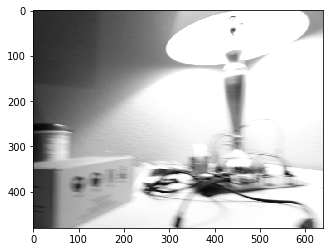

In [9]:
plt.imshow(imgs[0], cmap='gray');

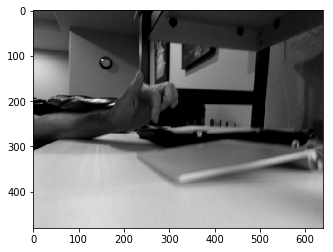

In [10]:
plt.imshow(imgs[900], cmap='gray');

In [13]:
def featureDetection():
    thresh = dict(threshold=25, nonmaxSuppression=True);
    fast = cv2.FastFeatureDetector_create(**thresh)
    return fast

In [18]:
def getAbsoluteScale(f0, f1):
      x_pre, y_pre, z_pre = f0
      x    , y    , z     = f1
      scale = np.sqrt((x-x_pre)**2 + (y-y_pre)**2 + (z-z_pre)**2)
      return x, y, z, scale

def featureTracking(img_1, img_2, p1):

    lk_params = dict( winSize  = (21,21),
                      maxLevel = 3,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

    p2, st, err = cv2.calcOpticalFlowPyrLK(img_1, img_2, p1, None, **lk_params)
    st = st.reshape(st.shape[0])
    ##find good one
    p1 = p1[st==1]
    p2 = p2[st==1]

    return p1,p2

In [54]:
def run(images):
    #initialization
#     ground_truth =getTruePose()

    img_1 = images[0]
    img_2 = images[0]

    if len(img_1) == 3:
        gray_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
        gray_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)
    else:
        gray_1 = img_1
        gray_2 = img_2

    #find the detector
    detector = featureDetection()
    kp1      = detector.detect(img_1)
    p1       = np.array([kp.pt for kp in kp1],dtype='float32')
    p1, p2   = featureTracking(gray_1, gray_2, p1)

    #Camera parameters
    fc = 718.8560
    pp = (640/2, 480/2)
#     K  = getK()

    E, mask = cv2.findEssentialMat(p2, p1, fc, pp, cv2.RANSAC,0.999,1.0);
    _, R, t, mask = cv2.recoverPose(E, p2, p1,focal=fc, pp = pp);

    #initialize some parameters
    MAX_FRAME     = 500
    MIN_NUM_FEAT  = 150

    preFeature = p2
    preImage   = gray_2

    R_f = R
    t_f = t

    maxError = 0
    ret_pos = []
    
    for numFrame in range(2, MAX_FRAME):

        if numFrame % 20 == 0:
            print(numFrame)

        if (len(preFeature) < MIN_NUM_FEAT):
            feature   = detector.detect(preImage)
            preFeature = np.array([ele.pt for ele in feature],dtype='float32')
            print(">> features found: ", len(preFeature))
            if len(preFeature) < MIN_NUM_FEAT:
                continue

        curImage_c = images[numFrame]

        if len(curImage_c) == 3:
              curImage = cv2.cvtColor(currImage_c, cv2.COLOR_BGR2GRAY)
        else:
              curImage = curImage_c

        kp1 = detector.detect(curImage);
        preFeature, curFeature = featureTracking(preImage, curImage, preFeature)
        E, mask = cv2.findEssentialMat(curFeature, preFeature, fc, pp, cv2.RANSAC,0.999,1.0);
        
#         print(E)
        
        _, R, t, mask = cv2.recoverPose(E, curFeature, preFeature, focal=fc, pp = pp);

#         truth_x, truth_y, truth_z, absolute_scale = getAbsoluteScale(
#             ground_truth[numFrame-1], ground_truth[numFrame])
        
#         if numFrame % 20 == 0:
#             print('scale', absolute_scale)

        absolute_scale = 1.0
            
        if absolute_scale > 0.1:
            t_f = t_f + absolute_scale*R_f.dot(t)
            R_f = R.dot(R_f)
        else:
            print("crap ... bad scale:", absolute_scale)

        preImage = curImage
        preFeature = curFeature

#         ret_pos.append((t_f[0], t_f[2],))
        ret_pos.append(t_f)

    return ret_pos

In [55]:
pos = run(imgs)

20
>> features found:  638
>> features found:  87
40
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
60
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
>> features found:  87
80
>> features found:  8

In [51]:
def getK():
    return   np.array([[7.188560000000e+02, 0, 6.071928000000e+02],
              [0, 7.188560000000e+02, 1.852157000000e+02],
              [0, 0, 1]])

ValueError: x and y can be no greater than 2-D, but have shapes (37,) and (37, 3, 1)

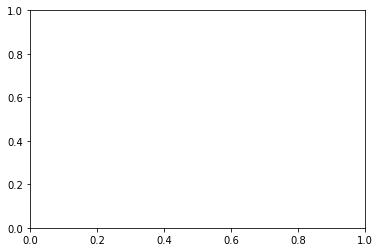

In [56]:
plt.plot(pos)

In [57]:
pos

[array([[-0.40693868],
        [-0.7098152 ],
        [ 0.69409058]]), array([[ 0.57504107],
        [-0.68305969],
        [ 0.50700797]]), array([[ 1.00156704],
        [-0.52120521],
        [ 1.39688365]]), array([[ 1.94562841],
        [-0.50226384],
        [ 1.06765826]]), array([[ 0.95371139],
        [-0.53147534],
        [ 1.19113825]]), array([[ 1.89245295],
        [-0.23279983],
        [ 1.01921616]]), array([[ 2.70181388],
        [-0.26300359],
        [ 1.60575058]]), array([[ 1.72023893],
        [-0.4457358 ],
        [ 1.66160363]]), array([[ 0.7392576 ],
        [-0.55217003],
        [ 1.82392241]]), array([[ 0.60492747],
        [-0.73916627],
        [ 2.7970554 ]]), array([[ 0.64647299],
        [-0.76910904],
        [ 3.79574324]]), array([[ 0.71596175],
        [-1.07172295],
        [ 4.74631998]]), array([[ 0.65088957],
        [-0.57350075],
        [ 3.88171588]]), array([[-0.34342886],
        [-0.59276203],
        [ 3.98640531]]), array([[-1.33294179

In [46]:
aa=np.array([1,2,3])

In [59]:
aa.transpose()

array([1, 2, 3])

In [48]:
aa[::2]

array([1, 3])